## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import hashlib
import warnings

warnings.filterwarnings('ignore')


## K-means

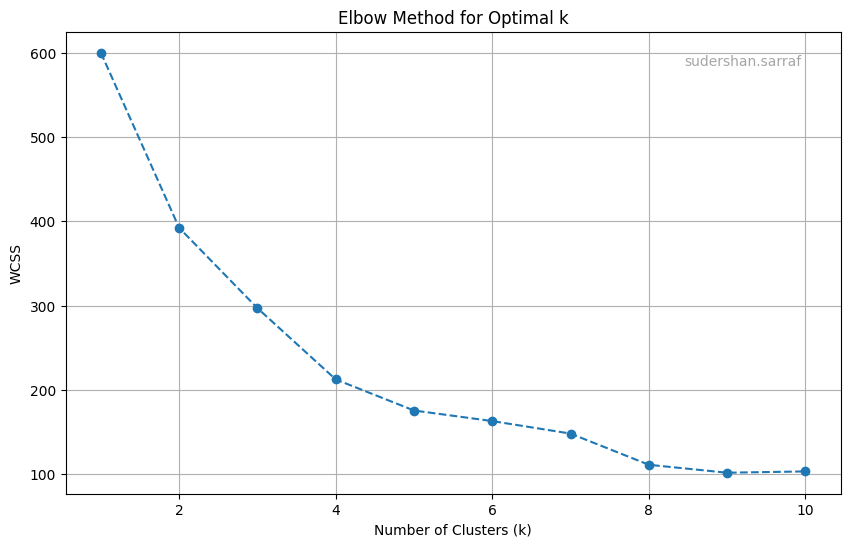

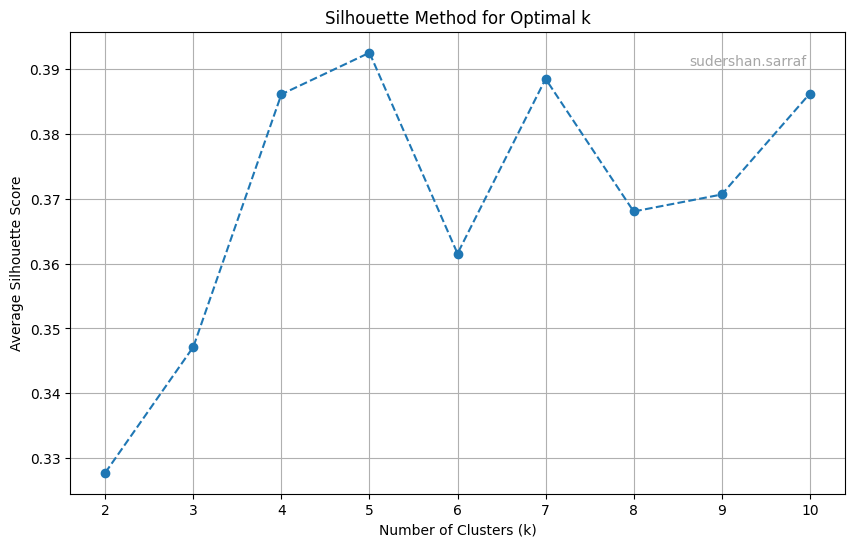

Analysis of Clusters at Optimal k=5:

Cluster 0:
  Number of customers: 38
  Average Age: 40.61
  Average Annual Income (k$): 86.11
  Average Spending Score (1-100): 19.58

Cluster 1:
  Number of customers: 58
  Average Age: 25.71
  Average Annual Income (k$): 42.90
  Average Spending Score (1-100): 60.95

Cluster 2:
  Number of customers: 44
  Average Age: 55.82
  Average Annual Income (k$): 55.25
  Average Spending Score (1-100): 49.11

Cluster 3:
  Number of customers: 20
  Average Age: 46.25
  Average Annual Income (k$): 26.75
  Average Spending Score (1-100): 18.35

Cluster 4:
  Number of customers: 40
  Average Age: 32.88
  Average Annual Income (k$): 86.10
  Average Spending Score (1-100): 81.53



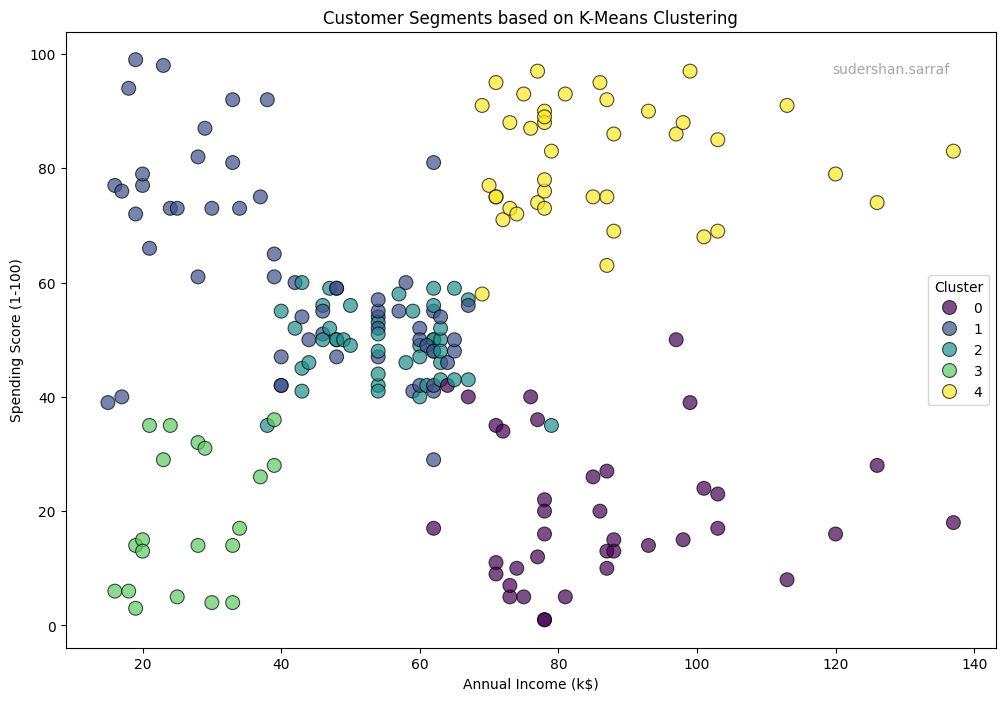

In [3]:
username = "sudershan.sarraf"
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
np.random.seed(seed)

# Data Loading and Preprocessing 
# Load the dataset and select numerical features for clustering.
df = pd.read_csv('Data/Clustering_dataset(in).csv')
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Handle missing values by filling them with the median of each column.
for col in numerical_features:
    df[col] = df[col].fillna(df[col].median())

X = df[numerical_features].copy()

# Scale the features to have a mean of 0 and standard deviation of 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Q2.1 Custom K-Means Class 

class KMeans:
    """A class for K-Means Clustering."""
    def __init__(self, k, max_iters=100):
        """Initializes the K-Means model."""
        self.k = k
        self.max_iters = max_iters
        self.centroids = None
        self.labels = None
        
    def _initialize_centroids(self, X):
        """Initializes centroids by picking random samples from the data."""
        n_samples = X.shape[0]
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        return X[random_indices]
    
    def _assign_clusters(self, X, centroids):
        """Assigns each data point to the nearest centroid."""
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)
    
    def _update_centroids(self, X, labels):
        """Updates centroids based on the mean of points in each cluster."""
        centroids = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            if np.sum(labels == i) > 0:
                centroids[i] = X[labels == i].mean(axis=0)
        return centroids
    
    def getCost(self, X, centroids, labels):
        """Calculates the Within-Cluster Sum of Squares (WCSS)."""
        wcss = 0
        for i in range(self.k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                wcss += np.sum((cluster_points - centroids[i])**2)
        return wcss
    
    def fit(self, X):
        """Trains the K-Means model."""
        self.centroids = self._initialize_centroids(X)
        
        for _ in range(self.max_iters):
            self.labels = self._assign_clusters(X, self.centroids)
            new_centroids = self._update_centroids(X, self.labels)
            
            # Check if centroids have converged.
            if np.allclose(self.centroids, new_centroids):
                break
                
            self.centroids = new_centroids
        return self
    
    def predict(self, X):
        """Assigns cluster numbers to new data points."""
        return self._assign_clusters(X, self.centroids)

# Q2.2 Determine the Optimal Number of Clusters 

def _add_username_to_plot(ax, username):
    """Helper function to add username watermark to plots."""
    ax.text(0.95, 0.95, username, ha='right', va='top', transform=ax.transAxes,
            fontsize=10, color='gray', alpha=0.7)

# Elbow Method
k_values = range(1, 11)
wcss_values = []
for k in k_values:
    kmeans = KMeans(k=k)
    kmeans.fit(X_scaled)
    wcss = kmeans.getCost(X_scaled, kmeans.centroids, kmeans.labels)
    wcss_values.append(wcss)

# Plot the Elbow curve.
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(k_values, wcss_values, marker='o', linestyle='--')
ax.set_title('Elbow Method for Optimal k')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('WCSS')
_add_username_to_plot(ax, username)
plt.grid(True)
plt.show()

# Silhouette Method
silhouette_scores = []
k_values_sil = range(2, 11)
for k in k_values_sil:
    kmeans = KMeans(k=k)
    kmeans.fit(X_scaled)
    labels = kmeans.labels
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot the Silhouette scores.
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(k_values_sil, silhouette_scores, marker='o', linestyle='--')
ax.set_title('Silhouette Method for Optimal k')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Average Silhouette Score')
_add_username_to_plot(ax, username)
plt.grid(True)
plt.show()

# Analysis of Clusters at Optimal k
optimal_k = 5  # As determined by the elbow and silhouette methods.
kmeans_final = KMeans(k=optimal_k)
kmeans_final.fit(X_scaled)
df['Cluster'] = kmeans_final.labels

# Print cluster characteristics.
print(f"Analysis of Clusters at Optimal k={optimal_k}:\n")
for i in range(optimal_k):
    cluster_data = df[df['Cluster'] == i]
    print(f"Cluster {i}:")
    print(f"  Number of customers: {len(cluster_data)}")
    print(f"  Average Age: {cluster_data['Age'].mean():.2f}")
    print(f"  Average Annual Income (k$): {cluster_data['Annual Income (k$)'].mean():.2f}")
    print(f"  Average Spending Score (1-100): {cluster_data['Spending Score (1-100)'].mean():.2f}\n")

# Visualize the clusters.
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis', s=100, alpha=0.7, edgecolor='k')
ax.set_title('Customer Segments based on K-Means Clustering')
_add_username_to_plot(ax, username)
plt.show()



# Question 2: K-Means Clustering Observations
For this question, I implemented the K-Means algorithm from scratch and used it to find the optimal number of customer segments in a dataset.

## Elbow Method:
The Elbow Method plot shows the WCSS (Within-Cluster Sum of Squares) for different numbers of clusters (k). There is a sharp decrease in WCSS as k increases from 1 to 3, and a distinct "elbow" or bend in the curve at k=5. After this point, the decrease in WCSS becomes much less significant, suggesting that adding more clusters provides diminishing returns.

## Silhouette Method:
The Silhouette Method plot shows the average silhouette score for different values of k. A higher score indicates better-defined clusters. The plot shows a peak at k=5, with a score of approximately 0.39, which is the highest score among the tested values. This confirms that 5 is a good choice for the number of clusters.

## Analysis of Clusters at Optimal k=5:
Based on these methods, I chose k=5 as the optimal number of clusters. The scatter plot clearly shows five distinct customer segments based on their income and spending scores:

### Cluster 0 (High Earners, Careful Spenders): 
This group has the highest average income (\$86.1k) but a very low spending score (19.58).

### Cluster 1 (Young Big Spenders): 
These are younger customers (average age 25.77) with lower incomes (\$42.9k) but very high spending scores (68.95).

### Cluster 2 (Average Customers): 
This is a large segment of middle-aged customers (average age 55.82) with moderate income (\$55.25) and spending habits (49.11).

### Cluster 3 (Low Income, Low Spending): 
This group is older on average (46.25) and has both the lowest income (\$26.75) and lowest spending score (18.35).

### Cluster 4 (Young Affluent Spenders): 
This is a key target group of younger customers (average age 32.88) with high incomes (\$86.1k) and high spending scores (81.53).

These clusters provide valuable insights into the different types of customers and can be used to create targeted marketing strategies. The clear separation of the clusters in the scatter plot confirms that K-Means was effective in segmenting this dataset.